# Non-Private Centralized Logistic Regression

In [20]:
# add files that we need!
import os
import sys
import logging 
logger = logging.getLogger()

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [21]:
from src.model.logistic_regression_models import MeanFieldMultiDimensionalLogisticRegression
from src.privacy_accounting.optimizer.standard_optimizer import StandardOptimizer
from src.privacy_accounting.analysis.moment_accountant import compute_privacy_loss_from_ledger


import torch
import torch.optim as optim

import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

# plotting
%matplotlib inline

In [22]:
prior_params = {
    "w_nat_mean": np.array([0.0, 0.0], dtype=np.float64),
    "w_pres": np.array([0.1, 0.1], dtype=np.float64) 
}

# initally local likelihood is zero - init at the prior!
current_params = prior_params 

hyperparameters = {
    "n_in": 2,
    "N_samples": 50,
    "N_steps": 500,
    "base_optimizer_class": optim.SGD,
    "base_optimizer_parameters": {'lr': 0.02},
    "wrapped_optimizer_class": StandardOptimizer,
    "wrapped_optimizer_parameters": {},
}

logRegressionModel = MeanFieldMultiDimensionalLogisticRegression(current_params, hyperparameters)

In [23]:
data_x = np.array([[2, 2], [1, 1], [0, 1], [1, 0], [-0.5, 0.1], 
                       [-1, -1], [-2, -2], [0, -1], [-1, 0],
                       [0.5, 0.1]], dtype=np.float64)
data_y = np.array([1, 1, 1, 1, 1, -1, -1, -1, -1, -1], dtype=np.float64)

def plot_results(data_x, data_y, opt_params):
    x_vals = data_x[:, 0]
    y_vals = data_x[:, 1]
    labels = data_y
    plt.figure()
    plt.grid(b=True)
    plt.scatter(x_vals, y_vals, c = labels)

    w_map = opt_params['w_nat_mean']/opt_params['w_pres']
    plt.arrow(0, 0, w_map[0], w_map[1], head_width=0.1)
    plt.plot([-2, 2], [(w_map[0]/w_map[1])*2, (w_map[0]/w_map[1])*-2])
    plt.show()
    
def plot_training(training_array):
    x_vals = np.arange(1, training_array.size+1)
    plt.figure()
    plt.plot(x_vals, training_array)
    plt.ylabel('ELBO Loss')
    plt.xlabel('Step')
    plt.show()
    
data = {
    "x": data_x,
    "y": data_y,
}

t = {
    "w_nat_mean": np.array([0, 0]),
    "w_pres": np.array([0, 0]) 
}


In [24]:
opt_params, training_curve = logRegressionModel.fit(data, t, prior_params, hyperparameters)

Loss: 18.572 after 0 steps
Loss: 6.370 after 25 steps
Loss: 5.586 after 50 steps
Loss: 4.802 after 75 steps
Loss: 5.136 after 100 steps
Loss: 4.974 after 125 steps
Loss: 4.910 after 150 steps
Loss: 5.045 after 175 steps
Loss: 4.934 after 200 steps
Loss: 5.124 after 225 steps
Loss: 4.966 after 250 steps
Loss: 4.843 after 275 steps
Loss: 4.643 after 300 steps
Loss: 4.881 after 325 steps
Loss: 5.197 after 350 steps
Loss: 4.585 after 375 steps
Loss: 4.639 after 400 steps
Loss: 4.834 after 425 steps
Loss: 4.812 after 450 steps
Loss: 4.822 after 475 steps


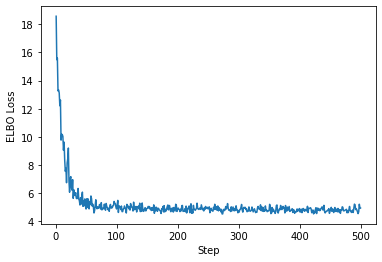

In [25]:
plot_training(training_curve)

{'w_nat_mean': array([0.82969401, 1.30853103]), 'w_pres': array([0.69652004, 0.41195339])}


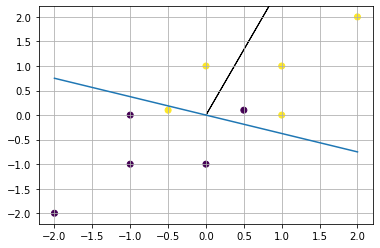

In [26]:
print(opt_params)
plot_results(data_x, data_y, opt_params)

## Let's use DP-SGD Instead!

In [27]:
from src.privacy_accounting.optimizer.dp_optimizer import DPGaussianOptimizer
from src.privacy_accounting.analysis import PrivacyLedger

ledger = PrivacyLedger(data_x.shape[0], 1)

hyperparameters = {
    "n_in": 2,
    "N_samples": 100,
    "N_steps": 1000,
    "base_optimizer_class": optim.SGD,
    "base_optimizer_parameters": {'lr': 0.01},
    "wrapped_optimizer_class": DPGaussianOptimizer,
    "wrapped_optimizer_parameters": {
                                     'l2_norm_clip':5.0,
                                     'noise_multiplier': 1,
                                     'num_microbatches': None,
                                     'ledger': ledger,
                                    }
}

logRegressionModel = MeanFieldMultiDimensionalLogisticRegression(current_params, hyperparameters)

Loss: 18.319 after 0 steps
Loss: 7.011 after 50 steps
Loss: 5.227 after 100 steps
Loss: 4.948 after 150 steps
Loss: 4.888 after 200 steps
Loss: 4.794 after 250 steps
Loss: 5.078 after 300 steps
Loss: 5.123 after 350 steps
Loss: 5.107 after 400 steps
Loss: 5.093 after 450 steps
Loss: 4.747 after 500 steps
Loss: 4.821 after 550 steps
Loss: 5.040 after 600 steps
Loss: 5.143 after 650 steps
Loss: 4.951 after 700 steps
Loss: 4.845 after 750 steps
Loss: 5.412 after 800 steps
Loss: 5.001 after 850 steps
Loss: 4.970 after 900 steps
Loss: 5.485 after 950 steps


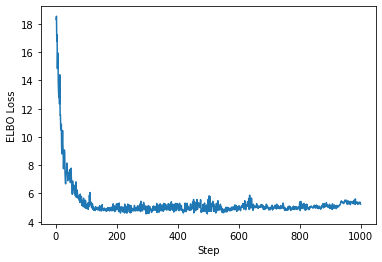

In [28]:
opt_params, training_curve = logRegressionModel.fit(data, t, prior_params, hyperparameters)
plot_training(training_curve)

{'w_nat_mean': array([0.58347261, 1.25070795]), 'w_pres': array([0.54879977, 0.38914192])}


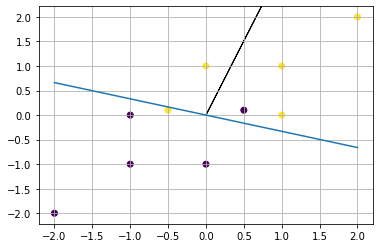

In [18]:
print(opt_params)
plot_results(data_x, data_y, opt_params)

## How private are we?

Let's compute an $(\epsilon, \delta)$ guarantee. It is required that $\delta << \frac{1}{N} = 0.1$, let's choose $\delta = 10^{-3}$

In [19]:
eps, delta = compute_privacy_loss_from_ledger(ledger.get_formatted_ledger(), 1e-3)

In [13]:
print(eps)

1006.9077552789821


Given no optimisation has been performed for privacy performance, and the total lack of subsampling, this incredibly weak privacy guarantee is not so surpising. 